In [2]:
import torch.onnx
import torchvision
import torch
import numpy as np
from torch.autograd import Variable
from model_thermal_rgb import Discriminator, Generator
from config import Config
from thermal_dataset import ThermalImageDataset as ImageDataset
from thermal_dataset import calc_temp
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm
import scipy.misc
from torchvision.utils import save_image
import torch.nn.functional as F

In [3]:
def move_image(input, x,y, border=cv2.BORDER_CONSTANT):
    pad_x = abs(x)
    pad_y = abs(y)
    shape = input.shape
    if len(shape) == 3:
        # Permute
        output = input.transpose(1,2,0)
        shape = output.shape
        output = cv2.copyMakeBorder(output, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1],:]
        output = output.transpose(2,0,1)

    else:
        output = cv2.copyMakeBorder(input, pad_y, pad_y, pad_x, pad_x, border)
        output = output[pad_y+y:pad_y+y+shape[0], pad_x+x:pad_x+x+shape[1]]

    return output

def move_tensor(input, x,y, border=cv2.BORDER_CONSTANT):
    orig_shape = input.shape
    np_image = input.squeeze().numpy()
    temp = move_image(np_image,x,y,border=border)

    return torch.FloatTensor(temp.reshape(orig_shape))

In [4]:
@torch.no_grad()
def matchTemplateTorch(img, template):
    img_tensor = torch.from_numpy(img).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    template_tensor = torch.from_numpy(template).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).cuda()
    result = matchTemplateTorchCore(img_tensor, template_tensor)
    return result.cpu().numpy()
@torch.jit.script    
def matchTemplateTorchCore(img_tensor, template_tensor):
    result1 = torch.nn.functional.conv2d(img_tensor, template_tensor, bias=None, stride=1, padding=0)
    result2 = torch.sqrt(torch.sum(template_tensor**2) * torch.nn.functional.conv2d(img_tensor**2, torch.ones_like(template_tensor), bias=None, stride=1, padding=0))

    return (result1/result2).squeeze(0).squeeze(0)
    #return (result1).squeeze(0).squeeze(0)

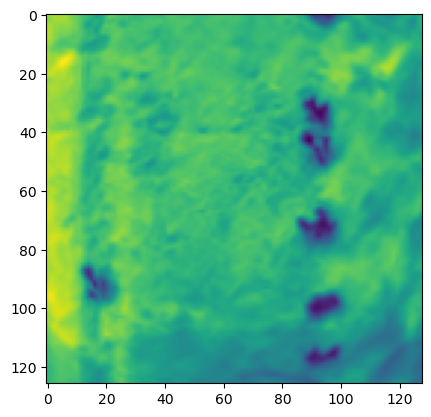

In [5]:
sample_dataset = ImageDataset(dataroot="/home/lion397/data/datasets/GEMINI/Training_T4_1_2_3/val",image_size=256, upscale_factor=4, mode="val", random_crop=True)  
#(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[20] # 늘 쓰던 Referene image
(low_img, rgb_img, high_ir) = sample_dataset.getImage(0) # 늘 쓰던 Referene image

plt.imshow(low_img)

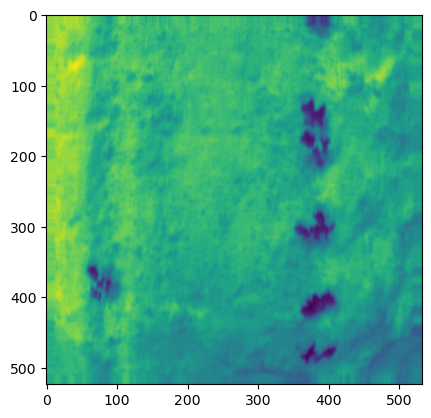

[[0.99954015 0.9995436  0.9995562  0.9995656  0.999588   0.99960315
  0.99961007 0.9996122  0.9995954  0.9995985  0.9995808  0.9995804
  0.9995775  0.9995855  0.99958014 0.9995729  0.99956524 0.99955475
  0.99955153 0.99954057 0.9995333 ]
 [0.99954545 0.99956393 0.99956673 0.99958193 0.99959403 0.9996051
  0.9996158  0.9996252  0.999611   0.9996072  0.9996099  0.999604
  0.9996028  0.9996024  0.9995963  0.99958915 0.99957657 0.9995667
  0.9995542  0.9995499  0.9995409 ]
 [0.99956083 0.9995687  0.999572   0.9995942  0.9995967  0.99961096
  0.99962693 0.9996345  0.99962246 0.99963146 0.99963385 0.9996251
  0.9996227  0.99961525 0.99961    0.99960643 0.99959505 0.9995861
  0.99956894 0.9995607  0.9995445 ]
 [0.99956673 0.9995647  0.99956423 0.9995938  0.9995933  0.99960804
  0.99962056 0.999642   0.9996446  0.99964714 0.99963844 0.99964654
  0.9996431  0.999631   0.99963033 0.99961364 0.9996114  0.99958897
  0.999579   0.9995634  0.9995497 ]
 [0.999579   0.9995745  0.99957955 0.9996028  0

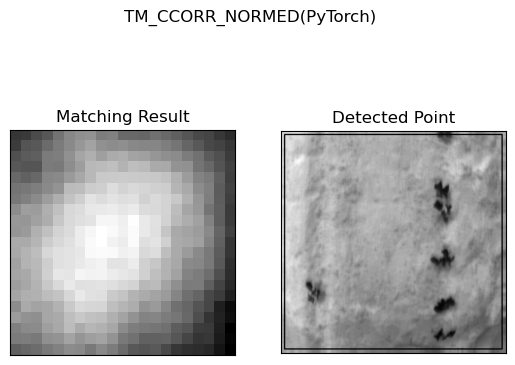

In [5]:
# Add image padding using opencv
img = cv2.copyMakeBorder(high_ir, 10, 10, 10, 10, cv2.BORDER_REPLICATE)
plt.imshow(img)
plt.show()
template = cv2.resize(low_img, dsize=(0, 0), fx=4, fy=4, interpolation=cv2.INTER_LINEAR)
# Apply template Matching
res = matchTemplateTorch(img,template)
print(res)
min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
w, h = template.shape[::-1]
# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

img_disp = img.copy()
# Normalize image
img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX, -1)

cv2.rectangle(img_disp,top_left, bottom_right, 0, 2)

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_disp,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED(PyTorch)')

plt.show()

tensor(8) tensor(13)
[13, 8]


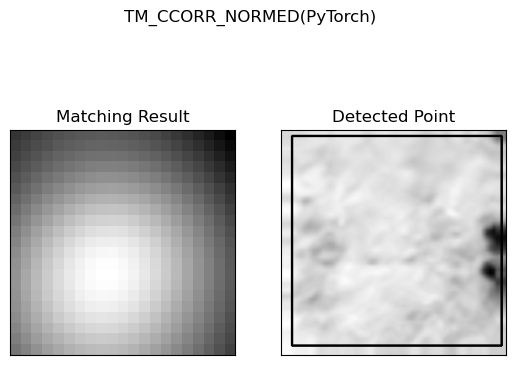

In [6]:
(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[0] # 늘 쓰던 Referene image
# Resize low torch tensor to high tensor size
low_img = F.interpolate(low_img.unsqueeze(0), size=(high_ir.shape[-2], high_ir.shape[-1]), mode='bilinear', align_corners=False)
# Add padding to low img
low_img = F.pad(low_img, (10, 10, 10, 10), mode='replicate')
high_ir = high_ir.unsqueeze(0)
res = matchTemplateTorchCore(low_img, high_ir)

if 1:
    result_max = torch.max(res)
    result_max_loc = torch.argmax(res)
    result_max_loc_x = result_max_loc % res.shape[0] 
    result_max_loc_y = result_max_loc // res.shape[1] 
    print(result_max_loc_x, result_max_loc_y)
    max_loc = [int(result_max_loc_y.detach().cpu().numpy()),int(result_max_loc_x.detach().cpu().numpy().squeeze())]
    print(max_loc)
else:
    res = res.squeeze(0).squeeze(0).cpu().numpy()
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

template = high_ir.detach().cpu().numpy().squeeze(0).squeeze(0)
w, h = template.shape[::-1]
# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

img_disp = low_img.detach().cpu().numpy().squeeze(0).squeeze(0)
# Normalize image
img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX, -1)
cv2.rectangle(img_disp,top_left, bottom_right, 0, 2)

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_disp,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED(PyTorch)')

plt.show()

tensor(11) tensor(7)
[7, 11]


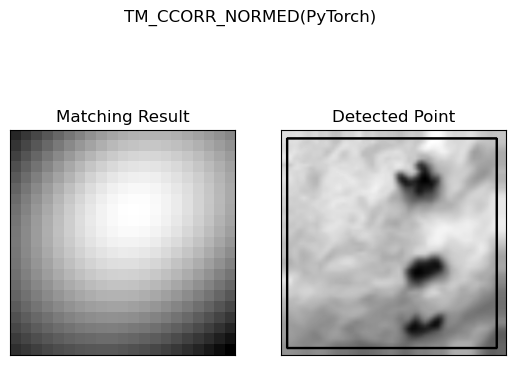

In [11]:
(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[0] # 늘 쓰던 Referene image
# Resize low torch tensor to high tensor size
low_img = F.interpolate(low_img.unsqueeze(0), size=(high_ir.shape[-2], high_ir.shape[-1]), mode='bilinear', align_corners=False)
# Add padding to low img
low_img = F.pad(low_img, (10, 10, 10, 10), mode='replicate')
high_ir = high_ir.unsqueeze(0)
res = matchTemplateTorchCore(low_img, high_ir)

if 1:
    result_max = torch.max(res)
    result_max_loc = torch.argmax(res)
    result_max_loc_x = result_max_loc % res.shape[0] 
    result_max_loc_y = result_max_loc // res.shape[1] 
    print(result_max_loc_x, result_max_loc_y)
    max_loc = [int(result_max_loc_y.detach().cpu().numpy()),int(result_max_loc_x.detach().cpu().numpy().squeeze())]
    print(max_loc)
else:
    res = res.squeeze(0).squeeze(0).cpu().numpy()
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)

template = high_ir.detach().cpu().numpy().squeeze(0).squeeze(0)
w, h = template.shape[::-1]
# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
top_left = max_loc
bottom_right = (top_left[0] + w, top_left[1] + h)

img_disp = low_img.detach().cpu().numpy().squeeze(0).squeeze(0)
# Normalize image
img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX, -1)
cv2.rectangle(img_disp,top_left, bottom_right, 0, 2)

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_disp,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED(PyTorch)')

plt.show()

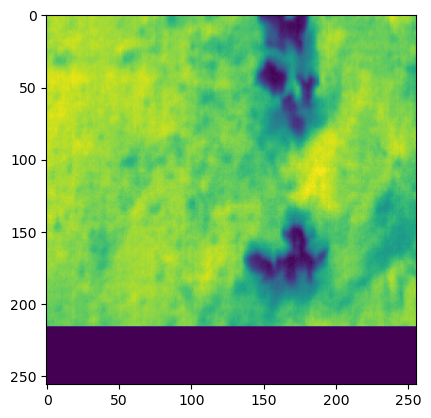

tensor(126) tensor(168)
[126, 168]
tensor([[[ 1.0000,  0.0000,  0.0156,  0.0000,  1.0000, -0.3125]]])


NameError: name 'res' is not defined

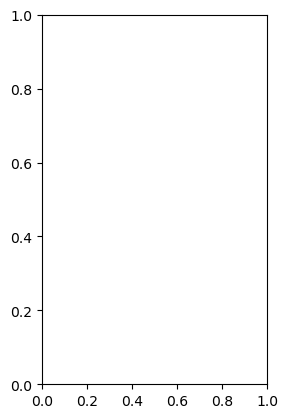

In [9]:
def matchTemplateTheta(background, template):
    background = F.interpolate(background.unsqueeze(0), size=(template.shape[-2], template.shape[-1]), mode='bilinear', align_corners=False)
    # Add padding to low img
    x_offset = background.shape[-2] // 2
    y_offset = background.shape[-1] // 2
    background = F.pad(background, (x_offset, x_offset, y_offset, y_offset), mode='replicate')
    res = matchTemplateTorchCore(background, template)

    result_max = torch.max(res)
    result_max_loc = torch.argmax(res)
    result_max_loc_x = result_max_loc % res.shape[0] 
    result_max_loc_y = result_max_loc // res.shape[1] 
    print(result_max_loc_x, result_max_loc_y)
    max_loc = [int(result_max_loc_x.detach().cpu().numpy()),int(result_max_loc_y.detach().cpu().numpy().squeeze())]
    print(max_loc)

    # Make theta matrix from max location
    theta = torch.tensor([1., 0., -2*(result_max_loc_x-x_offset)/ template.shape[-2], 0., 1., -2*(result_max_loc_y-y_offset) / template.shape[-1]])
    theta = theta.unsqueeze(0).repeat(background.shape[0],1,1)

    return max_loc, background, theta

(low_img, rgb_img, high_ir, thermal_info) = sample_dataset[0] # 늘 쓰던 Referene image
high_ir_move = move_tensor(high_ir,0,40)
plt.imshow(high_ir_move.detach().cpu().numpy().squeeze(0))
plt.show()
low_img = F.interpolate(low_img.unsqueeze(0), size=(high_ir_move.shape[-2], high_ir_move.shape[-1]), mode='bilinear', align_corners=False)
max_loc, background, theta = matchTemplateTheta(low_img.squeeze(0), high_ir_move.unsqueeze(0))
print(theta)
template = high_ir.detach().cpu().numpy().squeeze()
# If the method is TM_SQDIFF or TM_SQDIFF_NORMED, take minimum
top_left = max_loc
bottom_right = (top_left[0] + template.shape[1], top_left[1] + template.shape[0])

img_disp = background.detach().cpu().numpy().squeeze(0).squeeze(0)
# Normalize image
img_disp = cv2.normalize(img_disp, None, 0, 255, cv2.NORM_MINMAX, -1)
cv2.rectangle(img_disp, top_left, bottom_right, 0, 2)

plt.subplot(121),plt.imshow(res,cmap = 'gray')
plt.title('Matching Result'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img_disp,cmap = 'gray')
plt.title('Detected Point'), plt.xticks([]), plt.yticks([])
plt.suptitle('TM_CCORR_NORMED(PyTorch)')

plt.show()

/data/heesup/miniconda3/envs/thermalSR/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


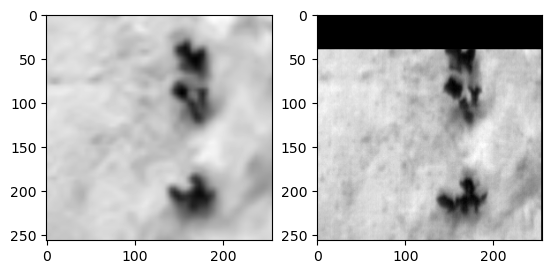

In [11]:
hr = high_ir_move.unsqueeze(0)
resampling_grid = F.affine_grid(theta.view(-1, 2, 3), hr.size())
high_ir_aligned = F.grid_sample(hr, resampling_grid, mode='bilinear', padding_mode='zeros', align_corners=False) # 'zeros', 'border', or 'reflection'

# Make 1x2 sbuplot
plt.subplot(121)
plt.imshow(low_img.squeeze().cpu().detach().numpy(), cmap='gray')
plt.subplot(122)
plt.imshow(high_ir_aligned.squeeze().cpu().detach().numpy(), cmap='gray')
plt.show()

torch.Size([4, 1, 64, 64]) torch.Size([4, 3, 256, 256]) torch.Size([4, 1, 256, 256])
tensor(129) tensor(130)
[129, 130]
tensor(121) tensor(134)
[121, 134]
tensor(128) tensor(130)
[128, 130]
tensor(126) tensor(134)
[126, 134]
tensor([[ 1.0000,  0.0000, -0.0078,  0.0000,  1.0000, -0.0156],
        [ 1.0000,  0.0000,  0.0547,  0.0000,  1.0000, -0.0469],
        [ 1.0000,  0.0000,  0.0000,  0.0000,  1.0000, -0.0156],
        [ 1.0000,  0.0000,  0.0156,  0.0000,  1.0000, -0.0469]])


/data/heesup/miniconda3/envs/thermalSR/lib/python3.9/site-packages/torch/nn/functional.py:4289: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


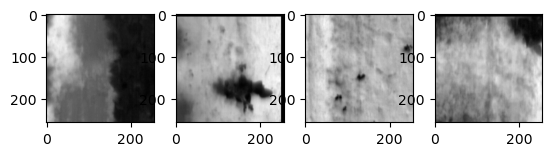

In [28]:
def matchTemplateThetaBatch(background, template):
    batch_size = background.shape[0]
    theta = torch.zeros(batch_size, 6)

    for i in range(batch_size):
        template_i = template[i].unsqueeze(0)
        background_i = F.interpolate(background[i].unsqueeze(0), size=(template_i.shape[-2], template_i.shape[-1]), mode='bilinear', align_corners=False)
        # Add padding to low img
        x_offset = background.shape[-2] // 2
        y_offset = background.shape[-1] // 2
        background_i = F.pad(background_i, (x_offset, x_offset, y_offset, y_offset), mode='replicate')
        res = matchTemplateTorchCore(background_i, template_i)
        result_max = torch.max(res)
        result_max_loc = torch.argmax(res)
        result_max_loc_x = result_max_loc % res.shape[0] 
        result_max_loc_y = result_max_loc // res.shape[1] 
        print(result_max_loc_x, result_max_loc_y)
        max_loc = [int(result_max_loc_x.detach().cpu().numpy()),int(result_max_loc_y.detach().cpu().numpy().squeeze())]
        print(max_loc)

        # Make theta matrix from max location
        theta[i] = torch.tensor([1., 0., -2*(result_max_loc_x-x_offset)/ template.shape[-2], 0., 1., -2*(result_max_loc_y-y_offset) / template_i.shape[-1]])
        theta[i] = theta[i].unsqueeze(0).repeat(background_i.shape[0],1,1)


    return max_loc, background, theta

# Test batch
from torch.utils.data import DataLoader
train_dataloader = DataLoader(sample_dataset,
                                  batch_size=4,
                                  shuffle=True,
                                  num_workers=0,
                                  pin_memory=True,
                                  persistent_workers=False)
for index, (lr, rgb, hr, thermal_info) in enumerate(train_dataloader):
    print(lr.shape, rgb.shape, hr.shape)
    lr_resized = F.interpolate(lr, size=(hr.shape[-2], hr.shape[-1]), mode='bilinear', align_corners=False)
    ax_loc, background, theta = matchTemplateThetaBatch(lr_resized, hr)
    resampling_grid = F.affine_grid(theta.view(-1, 2, 3), hr.size())
    high_ir_aligned = F.grid_sample(hr, resampling_grid, mode='bilinear', padding_mode='zeros', align_corners=False) # 'zeros', 'border', or 'reflection'
    print(theta)
    break

# Make 1x4 subplot using for loop

for i in range(4):
    plt.subplot(int(f"14{i+1}"))
    plt.imshow(high_ir_aligned[i].squeeze().cpu().detach().numpy(), cmap='gray')

